In [8]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import torch
import torch.nn as nn
import numpy as np
from torch.autograd import Variable
import torchtext
from torchtext import data
import os
from torchtext.data import get_tokenizer
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Transformers
Built with encoder-decoder architecture.
- The encoder maps an input sequence of length $n$, **x** $ = (x_{0}, ... , x_{n})$ to a continuous representation **z** $= (z_{0}, ... , z_{n})$.
- Given **z** the decoder generates the outputs **y** $ = (y_{0}, ... , y_{m})$ where $m$ is length of output sequence.

![Transformers](ModalNet-21.png)


- The model is auto-regressive meaning each predicted item (word) is predicted from the previous decoder input $y_{n-1}$ 


## Self-Attention
A mapping of a query and a set of key-value pairs to an output, where the query, keys, values, and output are vectors.

For each input element $x_{i}$:

**Feature vectors**
- **Query**: describes what to look for in a sequence
- **Key**: designed in a way to identify which elements to pay attention to given a query
- **Value**: the vector to average over

These three matricies are created by multiplying the embedded input matrix $\textbf{x}$ by three weight matricies created during the training process:

$$Q = W^{(Q)} \times X $$
$$K = W^{(K)} \times X $$
$$V = W^{(V)} \times X $$

$W^{(q)}, W^{(k)}$ with dimensions **number of input embeddings** X **dimension of the model** and \
$W^{(v)}$ can vary in dimension depending on the target embedding (**y**) size: **number of target embeddings** X **dimension of the model**

Lastly, the final vector:

- **Score function**: takes a query and a key and outputs the score/attention weight of the query-key pair

#### But how to calculate the score/attention weights?

### Scaled dot product

The attention/score value from element **i** to **j** is based on its similarity of the query $\mathcal{Q}_{i}$ and key $\mathcal{K}_{j}$, using the dot product as the similarity metric. Can calculate the dot product attention as follows:

$$Attention = \sum_{i}\alpha_{i} * value_{i} = softmax\left(\frac{QK^{T}}{\sqrt{d_{k}}}\right)V$$

resulting in a matrix with score outputs for every possible pair of queries and keys.

Now lets have a play:



In [9]:
# define the scaled dot product function to calculate scores

def scaled_dot_product(
    
    q: torch.tensor, 
    k: torch.tensor, 
    v: torch.tensor, 
    mask: torch.tensor=None    # NOTE: masks are generally used when training inputs of varied length

) -> (torch.tensor, torch.tensor):
     
    # dimension of k 
    dimension_k = q.size()[-1]
    
    # attention logits calculated
    attn_logits = torch.matmul(q, k.transpose(-2, -1))
    
    # normalized logits
    attn_logits = attn_logits / np.sqrt(dimension_k)
    
    # check if masking is needed
    if mask is not None:
        
        attn_logits = attn_logits.masked_fill(mask == 0, -9e15)
    
    # calculate the attention
    attention = F.softmax(attn_logits, dim=-1)
    
    # multiply by the value matrix
    values = torch.matmul(attention, v)
    
    return values, attention


# ===================================================================

# test with random tensors

#

seq_len, d_k = 8, 512

# initiate q, k, v
q = torch.randn(seq_len, d_k)
k = torch.randn(seq_len, d_k)
v = torch.randn(seq_len, d_k)

# calculate the attention and values
scores, attention = scaled_dot_product(q, k, v)
print("Q\n", q.shape)
print("K\n", k.shape)
print("V\n", v.shape)
print("Values\n", scores.shape)
print("Attention\n", attention.shape)

# ===================================================================

# test with random tensors different output value lengths (french - > english)

#

seq_len, d_k = 8, 512
d_v = 256

# initiate q, k, v
q = torch.randn(seq_len, d_k)
k = torch.randn(seq_len, d_k)
v = torch.randn(seq_len, d_v)

# calculate the attention and values
scores, attention = scaled_dot_product(q, k, v)
print("\n\n")
print("Q\n", q.shape)
print("K\n", k.shape)
print("V\n", v.shape)
print("Values\n", scores.shape)
print("Attention\n", attention.shape)


Q
 torch.Size([8, 512])
K
 torch.Size([8, 512])
V
 torch.Size([8, 512])
Values
 torch.Size([8, 512])
Attention
 torch.Size([8, 8])



Q
 torch.Size([8, 512])
K
 torch.Size([8, 512])
V
 torch.Size([8, 256])
Values
 torch.Size([8, 256])
Attention
 torch.Size([8, 8])


## Multihead attention

Gives multiple different query-key-value triplets over same features to capture different notions of similarity. Given a query, key, and value matrix, sub-queries, sub-keys, and sub-values are created and pass through the scaled dot product attention independently. Therefore given a query $\mathcal{q} \in \mathbb{R}^{d_{q}}$ keys $\mathcal{k} \in \mathbb{R}^{d_{k}}$ and values $\mathcal{v} \in \mathbb{R}^{d_{v}}$ the $\mathcal{i}$'th head is: 

$$\mathcal{h}_{i} = Attention(W_{i}^{(q)}q, \{W_{i}^{(k)}k, W_{i}^{(v)}v\}) \in \mathbb{R}^{p_{v}}$$

where $W_{i}^{(q)}, W_{i}^{(k)}, W_{i}^{(v)}$ are projection matricies / the learnable parameters.

Now stack/concatenate the heads together and project to $\mathbb{R}^{p_{0}}$:

$$\textbf{h} = MultiHeadAttn(q, \{k_{j}, v_{j}\}) = W_{o}\begin{bmatrix}
           h_{1} \\
           \vdots \\
           h_{h}
         \end{bmatrix} \in \mathbb{R}^{p_{0}}$$
         
where $W_{o} \in \mathbb{R}^{p_{0} \times hp_{v}}$

Another perk of the multihead attention is that each head can be calculated in parallel.
         
Let look at the implimentation:


In [10]:
class MultiheadAttention(nn.Module):

    def __init__(self, input_dim: int, dim_model: int, num_heads: int):
        
        super().__init__()
        
        assert dim_model % num_heads == 0, "Embedding dimension must be 0 modulo number of heads."

        # set the embedind dimension
        self.embed_dim = dim_model
        self.num_heads = num_heads
        self.head_dim = dim_model // num_heads

        # Stack all weight matrices 1...h together for efficiency
        self.qkv_proj = nn.Linear(input_dim, 3*dim_model)
        self.o_proj = nn.Linear(dim_model, dim_model)

        self._reset_parameters()

    def _reset_parameters(self):
        
        # Original Transformer initialization, see PyTorch documentation
        nn.init.xavier_uniform_(self.qkv_proj.weight)
        self.qkv_proj.bias.data.fill_(0)
        nn.init.xavier_uniform_(self.o_proj.weight)
        self.o_proj.bias.data.fill_(0)

    def forward(
        
        self, 
        x: torch.tensor,
        hx: torch.tensor=None,
        mask: torch.tensor=None
    
    ) -> (torch.tensor, torch.tensor):
        
        # extract dimensions of the embedding x
        batch_size, seq_length, embed_dim = x.size()
        qkv = self.qkv_proj(x)

        # Separate Q, K, V from linear output
        qkv = qkv.reshape(batch_size, seq_length, self.num_heads, 3*self.head_dim)
        qkv = qkv.permute(0, 2, 1, 3) # [Batch, Head, SeqLen, Dims]
        q, k, v = qkv.chunk(3, dim=-1)
        
        # for the case of encoder-decoder attention
        if hx is not None:
            
            qkv_x = self.qkv_proj(hx)
            
            # Separate Q, K, V from linear output
            qkv_x = qkv_x.reshape(batch_size, seq_length, self.num_heads, 3*self.head_dim)
            qkv_x = qkv_x.permute(0, 2, 1, 3) # [Batch, Head, SeqLen, Dims]
            q, k, v_x = qkv.chunk(3, dim=-1)           

        # Determine value outputs
        values, attention = scaled_dot_product(q, k, v, mask=mask)
        values = values.permute(0, 2, 1, 3) # [Batch, SeqLen, Head, Dims]
        values = values.reshape(batch_size, seq_length, embed_dim)
        o = self.o_proj(values)

        return o, attention
        

# ===================================================================

# test with random tensors

#

mha = MultiheadAttention(512, dim_model=512, num_heads=8)
sample_sentence = torch.randn(8, 8, 512)
output, attn = mha(pos_emb_text)

print("mha output\n", output.shape)
print("Attention\n", attn.shape)

mha output
 torch.Size([1, 32, 512])
Attention
 torch.Size([1, 8, 32, 32])


## Encoder

A single block contains:

- attention layer
- 2 normalization layers
- 2 layer MLP
- dropout layer

The overall encoder is **N** blocks and results in an encoding of the input:

$$\textbf{H}_{x} \in \mathbb{R}^{T_{x} \mathrm{x} \mathcal{D}}$$

where $T_{x}$ is number of input tokens and $\mathcal{D}$ is the attention vector dimensions

In [130]:
class EncoderBlock(nn.Module):

    def __init__(self, input_dim: int, num_heads: int, dim_feedforward: int, dropout: float=0.0):

        super().__init__()

        # Attention layer
        self.self_attn = MultiheadAttention(input_dim, input_dim, num_heads)

        # Two-layer MLP
        self.linear_net = nn.Sequential(
            nn.Linear(input_dim, dim_feedforward),
            nn.Dropout(dropout),
            nn.ReLU(inplace=True),
            nn.Linear(dim_feedforward, input_dim)
        )

        # Layers to apply in between the main layers
        self.norm1 = nn.LayerNorm(input_dim)
        self.norm2 = nn.LayerNorm(input_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.tensor, mask=None) -> torch.tensor:
        
        # Attention part
        attn_out = self.self_attn(x, mask=mask)
        x = x + self.dropout(attn_out)
        x = self.norm1(x)

        # MLP part
        linear_out = self.linear_net(x)
        x = x + self.dropout(linear_out)
        x = self.norm2(x)

        return x

    
class EncoderLayer(nn.Module):

    def __init__(self, num_layers: int, **block_args):
        
        super().__init__()
        
        # create the N blocks
        self.layers = nn.ModuleList([EncoderBlock(**block_args) for _ in range(num_layers)])

    def forward(self, x: torch.tensor, mask: torch.tensor=None) -> torch.tensor:
        
        # evaluate each layer
        for l in self.layers:
            
            x = l(x, mask=mask)
        
        return x

    def get_attention_maps(self, x: torch.tensor, mask=None) -> list:
        
        attention_maps = []
        
        for l in self.layers:
            
            _, attn_map = l.self_attn(x, mask=mask, return_attention=True)
            attention_maps.append(attn_map)
            x = l(x)
        
        return attention_maps

## Decoder

Once the input is encoded, the output is generated by the decoder. Though similar mechanisms, the decoder includes an addition attention. 

#### decoder attention
- attends all previous generated tokens; $y_{1:t-1}$ and computes: $$\textbf{H}_{y} \in \mathbb{R}^{T_{y} \mathrm{x} \mathcal{D}}$$
- A mask is also applied here so that output at step $\mathcal{t}$ only attends to locations prior to $\mathcal{t}$ in **Y**. This builds on the notion of context.

#### encoder-decoder attention
Attends to both the encoding of the input, $\textbf{H}_{x}$, and the previously generated outputs, $\textbf{H}_{y}$. These are combined to compute: 

$$Z = Attn(Q = Hx, K = Hx, V = Hy)$$ 

which compares the output to the input.The full decoder repeats this decoder block N times.
At the end of the decoder, the final output is mapped to a sequence of Ty output logits via a final
linear layer.

In [ ]:
class DecoderBlock(nn.Module):

    def __init__(self, input_dim: int, num_heads: int, dim_feedforward: int, dropout: float=0.0):

        super().__init__()

        # Attention layer
        self.self_attn = MultiheadAttention(input_dim, input_dim, num_heads)
        
        # encoder-decoder Attention layer
        self.src_attn = MultiheadAttention(input_dim, input_dim, num_heads)

        # Two-layer MLP
        self.linear_net = nn.Sequential(
            nn.Linear(input_dim, dim_feedforward),
            nn.Dropout(dropout),
            nn.ReLU(inplace=True),
            nn.Linear(dim_feedforward, input_dim)
        )

        # Layers to apply in between the main layers
        self.norm1 = nn.LayerNorm(input_dim)
        self.norm2 = nn.LayerNorm(input_dim)
        self.norm3 = nn.LayerNorm(input_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.tensor, hx: torch.tensor, mask=None) -> torch.tensor:
        
        # Attention part
        attn_out = self.self_attn(x, mask=mask)
        x = x + self.dropout(attn_out)
        x = self.norm1(x)
        
        # encoder-decoder Attention part
        src_attn_out = self.src_attn(x, hx, mask=mask)
        x = x + self.dropout(src_attn_out)
        x = self.norm1(x)

        # MLP part
        linear_out = self.linear_net(x)
        x = x + self.dropout(linear_out)
        x = self.norm2(x)

        return x

# Decoder is made of self-attn, src-attn, and feed forward (defined below)
class DecoderLayer(nn.Module):
    
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        
        super(DecoderLayer, self).__init__()
        
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)
 
    
    def forward(self, x, memory, src_mask, tgt_mask):

        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, src_mask))
        
        return self.sublayer[2](x, self.feed_forward)

### Masking example

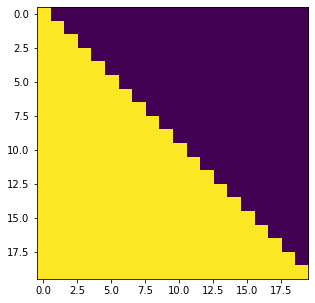

In [2]:
def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

plt.figure(figsize=(5,5))
plt.imshow(subsequent_mask(20)[0])
plt.show()

## Create the transformer

In [ ]:
class transformer(nn.Module):
   
    def __init__(
        self, 
        encoder: nn.Module,
        decoder: nn.Module, 
        src_embed: torch.tensor, 
        tgt_embed: torch.tensor, 
        d_model: int
    ):
        
        super(EncoderDecoder, self).__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.proj = nn.Linear(d_model, tgt_embed)
        
    def forward(self, src, tgt, src_mask, tgt_mask):
        
        #Take in and process masked src and target sequences
        hx = self.encoder(src, src_mask)
        hy = self.dencoder(tgt, hx, tgt_mask)
        
        return F.log_softmax(self.proj(hy), dim=-1)
        

## Tokenizing a sentence
- takes in a string sentence and splits it into its tokens
- converts token list into a torch tensor

In [103]:
# use pytorch's tokenizer module to create a tokenizing function
tokenizer = get_tokenizer("basic_english")

# tokenize our senetence
tokens = tokenizer("This is a pytorch tutorial for tokenization!")

# create a numpy array to hold the token list
sentence_np = np.linspace(0,len(tokens), len(tokens), False)

# convert to torch tensor
sentence_torch = torch.tensor(sentence_np, dtype=torch.long)

print(f"\n\n our test sentence : {sentence_torch.shape}\n\n")



 our test sentence : torch.Size([8])




## Create an embedding function for our intput
- creates a embedded object of our sentence (A simple lookup table that stores embeddings of a fixed dictionary and size)
- size of embedderis vocabulary size by model dimension. 

In [57]:
class Embedder(nn.Module):
    
    def __init__(self, vocab_size: int, d_model: int):
        super().__init__()
        
        self.d_model = d_model
        self.embed = nn.Embedding(vocab_size, d_model)
    
    def forward(self, x: torch.tensor) -> torch.tensor:
        
        return self.embed(x)
    
# create the embedding
embed = Embedder(4000, 512)

# get embedded text
embed_text = embed(sentence_torch)

print(embed_text.shape)

torch.Size([8, 512])


## Create the Positional Embedding function
- embeds a position to each token so the model can learn what order the input items are in
- incorporates a dropout functionality

In [4]:
# Implement the PE function

class PositionalEncoding(nn.Module):
    
    def __init__(self, d_model: int, dropout: float=0.1, max_len=512):
        super(PositionalEncoding, self).__init__()
        
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x: torch.tensor) -> torch.tensor:
        
#         print(f"shape {Variable(self.pe[:, :x.size(0)], requires_grad=False).shape}")
        
        x = x + Variable(self.pe[:, :x.size(1)], 
                         requires_grad=False)
        
        return self.dropout(x)

# =====================================================================================

# testing positional encoder

#

pos_emb = PositionalEncoding(512, 0.1)
embed_text = torch.zeros(1, 32, 512)
pos_emb_text = pos_emb(embed_text)

print(pos_emb.pe.shape, pos_emb_text.shape)

torch.Size([1, 512, 512]) torch.Size([1, 32, 512])


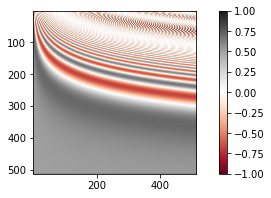

In [5]:
pe = pos_emb.pe.squeeze().T.cpu().numpy()
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,3))
pos = ax.imshow(pe, cmap="RdGy", extent=(1,pe.shape[1]+1,pe.shape[0]+1,1))
fig.colorbar(pos, ax=ax)

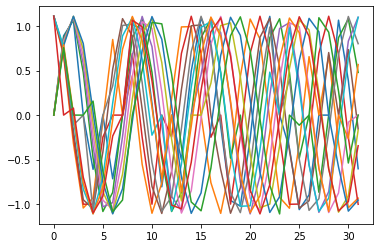

In [6]:
plt.plot(np.arange(32), pos_emb_text[0, :, 4:18].data.numpy())
# plt.legend(["dim %d"%p for p in [4,5,6,7]])

In [ ]:
self.proj = nn.Linear(d_model, vocab)